In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import os.path
#import one_hot_encoder
#import utils
import random
from collections import Counter
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
merge_1month = pd.read_csv('merge_1month.csv')

In [3]:
len(merge_1month)

383

In [4]:
merge_1month.isna().sum()

Date                                                0
CESIGL Index                                      183
CESIGL Index 1 month absolute delta               184
CESIGL Index 2 month absolute delta               185
CESIGL Index 3 month absolute delta               186
CESIGL Index 12 month absolute delta              195
CESIGL Index 2 mo avg                             184
CESIGL Index 3 mo avg                             185
CESIGL Index 6 mo avg                             188
CESIGL Index 6 mo avg - 3 mo avg                  188
JPEASIEM Index                                    147
JPEASIEM Index 1 month absolute delta             148
JPEASIEM Index 2 month absolute delta             149
JPEASIEM Index 3 month absolute delta             150
JPEASIEM Index 12 month absolute delta            159
JPEASIEM Index 2 mo avg                           148
JPEASIEM Index 3 mo avg                           149
JPEASIEM Index 6 mo avg                           152
JPEASIEM Index 6 mo avg - 3 

In [5]:
nan_non_zero_count = []
for i in range(len(merge_1month)):
    nan_non_zero_count.append(np.count_nonzero((merge_1month.iloc[i:len(merge_1month)-1].isna().sum()/len(merge_1month)).values))

In [6]:
#nan_non_zero_count

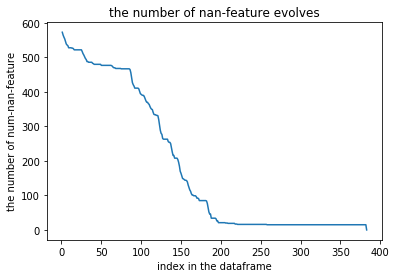

In [7]:
x_plot = list(range(1,384))
plt.plot(x_plot,nan_non_zero_count)
plt.title('the number of nan-feature evolves')
plt.ylabel('the number of num-nan-feature')
plt.xlabel('index in the dataframe')
plt.show()

In [8]:
merge_1month_X = merge_1month[merge_1month.columns[:-15]]

In [9]:
merge_1month_X = merge_1month_X.replace([np.inf, -np.inf], np.nan)

In [10]:
merge_1month_Y = merge_1month[merge_1month.columns[-15:]]

The n-order absolute left co-moment of $X$ and $Y$ is defined by $E[|X|^{n-1}|Y|]$  

The score is defined by $$\frac{1}{2}absCorr+\frac{1}{6}absCosk+\frac{1}{24}absCoku$$

where the $absCorr$, $absCosk$ and $absCoku$ are the 2,3,4 order absolute left co-moment

In [11]:
def abs_left_co_moment(X,y,dim,isCentralized = False):
    """
    This function calculates the n-order abs left co-moments
    
    inputs:
    X || Dataframe, includes colunms for to calculate the co-moment with y one-by-one
    y || Dataframe , includes one colunms to calculate the co-moment with multiple x in the X
    isCentralized || Boolean, if "True", use the centralized version of the X and y
                                if "False", use the original inputs to calculate
                                
    Output:
    result || Series, includes the co-moment for different x in X
    """
    cols = X.columns
    if isCentralized:
        X = X - X.mean()
        y = y - y.mean()
    vx = np.abs(X.values.T)
    vy = np.abs(y.values.T)
    result = []
    for i in range(len(vx)):
        result.append(np.mean(np.power(vx[i],(dim-1))*vy)/np.power((np.power(np.mean(np.power(vx[i],dim)),dim-1)*np.mean(np.power(vy,dim))),1/dim))
    result = pd.Series(result, index =cols) 
    return result
def get_score(X,y,isCentralized = False):
    """
    This function calculates the score: 1/2 absCorr + 1/6 absCosk + 1/24 absCoku
    inputs:
    X || Dataframe, includes colunms for to calculate the co-moment with y one-by-one
    y || Dataframe , includes one colunms to calculate the co-moment with multiple x in the X
    isCentralized || Boolean, if "True", use the centralized version of the X and y
                                if "False", use the original inputs to calculate
                                
    Output:
    score || Series, includes the score for different x in X
    """
    abs_corr = abs_left_co_moment(X, y,2,isCentralized)
    abs_cosk = abs_left_co_moment(X, y,3,isCentralized)
    abs_coku = abs_left_co_moment(X, y,4,isCentralized)
    score = 0.5*abs_corr+1/6*abs_cosk+1/24*abs_coku
    return score
def gen_MC_signals(y,dist):
    """
    This function generates len(y) realizations from a givem distribution
    
    inputs:
    y || dataframe, contains one list of target variables
    dist || accept any API from: https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html#distributions
    
    output:
    dataframe || contains one column which is the MC signals
    e.g.: gen_MC_signals(y,np.random.standard_normal)
    """
    random = dist(size=len(y))
    return pd.Series(random).to_frame()
def filter_by_comoment(X,y,w=1,isCentralized = False):
    """
    This function first calculates the MC bar of a given target variable y and filter out features by the MCbar
    example: filter_by_comoment(merge_1month_X_df1, y,1.2)[0]
    
    inputs:
    X || Dataframe, includes colunms for to calculate the co-moment with y one-by-one
    y || Dataframe , includes one colunms to calculate the co-moment with multiple x in the X
    isCentralized || Boolean, if "True", use the centralized version of the X and y
                                if "False", use the original inputs to calculate
                                
    outputs:
    list || a list contains the name of the features after filtered
    list || a pd.Series that contains the scores of the above festures
    """
    score = get_score(X,y,isCentralized = False)
    MC_bars = []
    for i in range(1000):
        MC_bars.append(get_score(gen_MC_signals(y,np.random.standard_normal),y).values[0])
    MC_bar = np.array(MC_bars).mean()
    return list(score[score.between(w*MC_bar,1, inclusive=False)].index), score[score.between(MC_bar,1, inclusive=False)]

### A Baseline: filled NaN with mean

In [12]:
import xgboost as xgb

In [13]:
merge_1month_X_df2 = merge_1month_X.copy()
merge_1month_X_df1 = merge_1month_X.iloc[127:].copy()
del merge_1month_X_df1['Date']
del merge_1month_X_df2['Date']

In [14]:
#merge_1month_X_df2 = merge_1month_X_df2.fillna(merge_1month_X_df2.mean())
#merge_1month_X_df1 = merge_1month_X_df1.fillna(merge_1month_X_df1.mean())

In [15]:
merge_1month_Y_df2 = merge_1month_Y.copy()
merge_1month_Y_df1 = merge_1month_Y.iloc[127:].copy()
merge_1month_Y_df1 = merge_1month_Y_df1.fillna(method = 'bfill')
merge_1month_Y_df1 = merge_1month_Y_df1.fillna(method = 'ffill')
merge_1month_Y_df2 = merge_1month_Y_df2.fillna(method = 'bfill')
merge_1month_Y_df2 = merge_1month_Y_df2.fillna(method = 'ffill')

In [16]:
def get_X_y(X,Y,y_name, is_use_other_y=True):
    """
    This function gives the X and y for the training and testing process
    
    inputs:
    X || dataframe, includes all the trianing data
    Y || dataframe, includes all the target data which should be trained one by one in the Classifiers
    y_name || string, the name of the variable in the Y.colunms which will be regarded as the target variable in this stage of training
    is_use_other_y || Boolean, if "True", we are going to concat the lag1 data in the Y (without the target for the model) into X 
    
    outputs:
    X || dataframe, may contain the lag1 data of the Y (without the target for the model)
    y || dataframe, includes one colnum which is the target variable in this model

    ================================== Explanation ==================================
    if is_use_other_y is True:
    e.g.
    inputs: X has colnums like X.colnums = [A, B, C, D, E, F]
            y has colnums like Y.colnums = [G, H, I]
            only G is the target in this model

    outputs: X has colnums like X.colnums = [A, B, C, D, E, F, H_lag1, I_lag1]
            y has one colnum which is G

    if is_use_other_y is False:
    the output will be:
    X has colnums like X.colnums = [A, B, C, D, E, F]
            y has one colnum which is G
    """
    X_1 = X.copy()
    Y_1 = Y.copy()
    y = Y_1[y_name].to_frame()
    #del X_1['Date']
    del Y_1[y_name]
    Y_1= Y_1.shift(-1)
    Y_1.fillna(method = 'ffill')
    if is_use_other_y:
        return pd.concat([X_1, Y_1], axis=1, sort=False), y
    else:
        return X_1,y

In [17]:
get_X_y(merge_1month_X_df2,merge_1month_Y_df2,merge_1month_Y_df2.columns[0])[0].columns.values

array(['CESIGL Index', 'CESIGL Index 1 month absolute delta',
       'CESIGL Index 2 month absolute delta',
       'CESIGL Index 3 month absolute delta',
       'CESIGL Index 12 month absolute delta', 'CESIGL Index 2 mo avg',
       'CESIGL Index 3 mo avg', 'CESIGL Index 6 mo avg',
       'CESIGL Index 6 mo avg - 3 mo avg', 'JPEASIEM Index',
       'JPEASIEM Index 1 month absolute delta',
       'JPEASIEM Index 2 month absolute delta',
       'JPEASIEM Index 3 month absolute delta',
       'JPEASIEM Index 12 month absolute delta',
       'JPEASIEM Index 2 mo avg', 'JPEASIEM Index 3 mo avg',
       'JPEASIEM Index 6 mo avg', 'JPEASIEM Index 6 mo avg - 3 mo avg',
       'CECICUSD INDEX', 'CECICUSD INDEX 1 month absolute delta',
       'CECICUSD INDEX 2 month absolute delta',
       'CECICUSD INDEX 3 month absolute delta',
       'CECICUSD INDEX 12 month absolute delta',
       'CECICUSD INDEX 2 mo avg', 'CECICUSD INDEX 3 mo avg',
       'CECICUSD INDEX 6 mo avg', 'CECICUSD INDEX 6 mo avg

In [18]:
def train_XGBs(X,Y,split1,split2,is_use_other_y=True,
               max_depth=3,learning_rate=0.1, n_estimators=300,
               verbosity=1, objective='binary:logistic',
               booster='gbtree', tree_method='auto', n_jobs=1, 
               gpu_id=-1, gamma=0, min_child_weight=1, 
               max_delta_step=0, subsample=1, colsample_bytree=1, 
               colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, 
               reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
               random_state=0, missing=None):
    import re
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
    Models = {}
    dev_yhats = {}
    scores = {}
    Model_features = {}
    prob_scores = {}
    AUROC = {}
    AUPR = {}
    FPs = {}
    X_old, Y_old = X, Y
    for col in Y.columns:
        X, Y = X_old, Y_old
        X,y = get_X_y(X,Y,col,is_use_other_y)
        train_X = X[:split1]
        train_X = train_X.fillna(train_X.mean())
        dev_X = X[split1:split2]
        dev_X = dev_X.fillna(X[:split2].mean())
        test_X = X[split2:]
        test_X = test_X.fillna(X.mean())
        train_y = y[:split1]
        dev_y = y[split1:split2]
        test_y = y[split2:]
        features = filter_by_comoment(train_X,train_y,w=1,isCentralized = False)[0]
        train_X = train_X[features]
        dev_X = dev_X[features]
        test_X = test_X[features]
        XGB = xgb.XGBClassifier(learning_rate=0.03, n_estimators=300, n_jobs=-1, silent=False)
        XGB.fit(train_X, train_y) 
        Models[col] = XGB
        dev_yhats[col] = XGB.predict(dev_X)
        scores[col] = XGB.score(dev_X, dev_y)
        Model_features[col] = features
        prob_scores[col] = XGB.predict_proba(dev_X)[:,1]
        AUROC[col] = roc_auc_score(dev_y, prob_scores[col])
        AUPR[col] = average_precision_score(dev_y, prob_scores[col])
        tn, fp, fn, tp = confusion_matrix(dev_y, dev_yhats[col]).ravel()
        FPs[col] = fp
    return Models,dev_yhats,scores,Model_features, prob_scores, AUROC, AUPR, FPs

### version of droppingthe first 127 obs

In [19]:
split11 = 200
split12 = 228

In [20]:
Models,dev_yhats,scores,Model_features, prob_scores, AUROC, AUPR, FPs = train_XGBs(merge_1month_X_df1,merge_1month_Y_df1,split11,split12,is_use_other_y=True)

D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [21]:
print("the out-of-sample scores for each model: ")
scores

the out-of-sample scores for each model: 


{'MSCI EM': 0.6428571428571429,
 'SPX 500 Price Return': 0.5714285714285714,
 'Eurostoxx 600': 0.6428571428571429,
 'MSCI Japan': 0.5714285714285714,
 'MSCI World': 0.7142857142857143,
 'Russell 2000': 0.42857142857142855,
 'Crude Oil Total Return': 0.4642857142857143,
 'CRB Metals': 0.4642857142857143,
 'Gold Price': 0.6071428571428571,
 'S&P GSCI Total Return Index': 0.5,
 'UST 7-10yr': 0.6785714285714286,
 'German 7-10yr': 0.4642857142857143,
 'US IG Corps': 0.4642857142857143,
 'US HY Corp': 0.42857142857142855,
 'US Mortgages': 0.5357142857142857}

In [22]:
print("the ROC for each model: ")
AUROC

the ROC for each model: 


{'MSCI EM': 0.6256410256410256,
 'SPX 500 Price Return': 0.5885416666666666,
 'Eurostoxx 600': 0.578125,
 'MSCI Japan': 0.5555555555555556,
 'MSCI World': 0.6042780748663102,
 'Russell 2000': 0.5294117647058824,
 'Crude Oil Total Return': 0.5347593582887701,
 'CRB Metals': 0.5260416666666667,
 'Gold Price': 0.6102564102564103,
 'S&P GSCI Total Return Index': 0.40625,
 'UST 7-10yr': 0.7540106951871657,
 'German 7-10yr': 0.4769230769230769,
 'US IG Corps': 0.5487179487179487,
 'US HY Corp': 0.5204081632653061,
 'US Mortgages': 0.59375}

In [23]:
print("the precision score for each model: ")
AUPR

the precision score for each model: 


{'MSCI EM': 0.726998286122327,
 'SPX 500 Price Return': 0.6465632512231776,
 'Eurostoxx 600': 0.6335126715919049,
 'MSCI Japan': 0.7819864454837758,
 'MSCI World': 0.6356670690580726,
 'Russell 2000': 0.6300999966217358,
 'Crude Oil Total Return': 0.5512118338402923,
 'CRB Metals': 0.4994974038166258,
 'Gold Price': 0.6984947862594921,
 'S&P GSCI Total Return Index': 0.4168619676295115,
 'UST 7-10yr': 0.7540573461626093,
 'German 7-10yr': 0.5249787968969555,
 'US IG Corps': 0.6336821463137252,
 'US HY Corp': 0.6390554626954449,
 'US Mortgages': 0.4929031050312515}

In [24]:
print("the FP for each model: ")
FPs

the FP for each model: 


{'MSCI EM': 8,
 'SPX 500 Price Return': 11,
 'Eurostoxx 600': 7,
 'MSCI Japan': 4,
 'MSCI World': 4,
 'Russell 2000': 3,
 'Crude Oil Total Return': 8,
 'CRB Metals': 10,
 'Gold Price': 5,
 'S&P GSCI Total Return Index': 6,
 'UST 7-10yr': 6,
 'German 7-10yr': 8,
 'US IG Corps': 3,
 'US HY Corp': 8,
 'US Mortgages': 8}

In [25]:
Models,dev_yhats,scores,Model_features, prob_scores, AUROC, AUPR, FPs = train_XGBs(merge_1month_X_df1,merge_1month_Y_df1,split11,split12,is_use_other_y=False)

D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [26]:
print("the out-of-sample scores for each model: ")
scores

the out-of-sample scores for each model: 


{'MSCI EM': 0.5357142857142857,
 'SPX 500 Price Return': 0.5714285714285714,
 'Eurostoxx 600': 0.5357142857142857,
 'MSCI Japan': 0.5714285714285714,
 'MSCI World': 0.42857142857142855,
 'Russell 2000': 0.5357142857142857,
 'Crude Oil Total Return': 0.5357142857142857,
 'CRB Metals': 0.5,
 'Gold Price': 0.42857142857142855,
 'S&P GSCI Total Return Index': 0.32142857142857145,
 'UST 7-10yr': 0.5357142857142857,
 'German 7-10yr': 0.5357142857142857,
 'US IG Corps': 0.42857142857142855,
 'US HY Corp': 0.4642857142857143,
 'US Mortgages': 0.5714285714285714}

In [27]:
print("the ROC for each model: ")
AUROC

the ROC for each model: 


{'MSCI EM': 0.5384615384615384,
 'SPX 500 Price Return': 0.6197916666666667,
 'Eurostoxx 600': 0.5572916666666667,
 'MSCI Japan': 0.5444444444444445,
 'MSCI World': 0.44919786096256686,
 'Russell 2000': 0.4919786096256684,
 'Crude Oil Total Return': 0.572192513368984,
 'CRB Metals': 0.5364583333333333,
 'Gold Price': 0.4923076923076922,
 'S&P GSCI Total Return Index': 0.24479166666666669,
 'UST 7-10yr': 0.5187165775401069,
 'German 7-10yr': 0.4820512820512821,
 'US IG Corps': 0.5692307692307692,
 'US HY Corp': 0.4693877551020408,
 'US Mortgages': 0.5833333333333334}

In [28]:
print("the precision score for each model: ")
AUPR

the precision score for each model: 


{'MSCI EM': 0.6707551843519,
 'SPX 500 Price Return': 0.6815375660165714,
 'Eurostoxx 600': 0.6795861494850466,
 'MSCI Japan': 0.7718543748253894,
 'MSCI World': 0.5935535300265531,
 'Russell 2000': 0.5926783848701533,
 'Crude Oil Total Return': 0.555649851962521,
 'CRB Metals': 0.4988339535707957,
 'Gold Price': 0.64207143533742,
 'S&P GSCI Total Return Index': 0.32250322653163993,
 'UST 7-10yr': 0.4999020595858541,
 'German 7-10yr': 0.5391511236229907,
 'US IG Corps': 0.6422883300274604,
 'US HY Corp': 0.6006743381113129,
 'US Mortgages': 0.49382903095717745}

In [29]:
print("the FP for each model: ")
FPs

the FP for each model: 


{'MSCI EM': 10,
 'SPX 500 Price Return': 11,
 'Eurostoxx 600': 8,
 'MSCI Japan': 4,
 'MSCI World': 6,
 'Russell 2000': 5,
 'Crude Oil Total Return': 7,
 'CRB Metals': 9,
 'Gold Price': 7,
 'S&P GSCI Total Return Index': 8,
 'UST 7-10yr': 8,
 'German 7-10yr': 9,
 'US IG Corps': 4,
 'US HY Corp': 7,
 'US Mortgages': 7}

### version of non-drop

In [30]:
split21 = 300
split22 = 350

In [31]:
Models,dev_yhats,scores,Model_features, prob_scores, AUROC, AUPR, FPs = train_XGBs(merge_1month_X_df2,merge_1month_Y_df2,split21,split22,is_use_other_y=True)

D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [32]:
print("the out-of-sample scores for each model: ")
scores

the out-of-sample scores for each model: 


{'MSCI EM': 0.5,
 'SPX 500 Price Return': 0.58,
 'Eurostoxx 600': 0.68,
 'MSCI Japan': 0.46,
 'MSCI World': 0.54,
 'Russell 2000': 0.5,
 'Crude Oil Total Return': 0.46,
 'CRB Metals': 0.46,
 'Gold Price': 0.46,
 'S&P GSCI Total Return Index': 0.54,
 'UST 7-10yr': 0.58,
 'German 7-10yr': 0.42,
 'US IG Corps': 0.62,
 'US HY Corp': 0.6,
 'US Mortgages': 0.6}

In [33]:
print("the ROC for each model: ")
AUROC

the ROC for each model: 


{'MSCI EM': 0.47916666666666663,
 'SPX 500 Price Return': 0.5055147058823529,
 'Eurostoxx 600': 0.6349745331069611,
 'MSCI Japan': 0.45161290322580644,
 'MSCI World': 0.5648604269293924,
 'Russell 2000': 0.5059422750424448,
 'Crude Oil Total Return': 0.37766830870279144,
 'CRB Metals': 0.49275362318840576,
 'Gold Price': 0.43842364532019706,
 'S&P GSCI Total Return Index': 0.5487012987012987,
 'UST 7-10yr': 0.4827586206896552,
 'German 7-10yr': 0.4736842105263158,
 'US IG Corps': 0.6208,
 'US HY Corp': 0.5861513687600644,
 'US Mortgages': 0.6223316912972086}

In [34]:
print("the precision score for each model: ")
AUPR

the precision score for each model: 


{'MSCI EM': 0.4894749977964607,
 'SPX 500 Price Return': 0.7208939460820374,
 'Eurostoxx 600': 0.725127130499805,
 'MSCI Japan': 0.5756148240247856,
 'MSCI World': 0.6800214524432102,
 'Russell 2000': 0.6305372937490925,
 'Crude Oil Total Return': 0.3552661732250966,
 'CRB Metals': 0.48578555096650056,
 'Gold Price': 0.37435731327726035,
 'S&P GSCI Total Return Index': 0.4955714031101523,
 'UST 7-10yr': 0.4555972538647104,
 'German 7-10yr': 0.5979538271449045,
 'US IG Corps': 0.6440618499022033,
 'US HY Corp': 0.5975214462585576,
 'US Mortgages': 0.6230423685728761}

In [35]:
print("the FP for each model: ")
FPs

the FP for each model: 


{'MSCI EM': 16,
 'SPX 500 Price Return': 11,
 'Eurostoxx 600': 10,
 'MSCI Japan': 9,
 'MSCI World': 12,
 'Russell 2000': 13,
 'Crude Oil Total Return': 23,
 'CRB Metals': 14,
 'Gold Price': 16,
 'S&P GSCI Total Return Index': 13,
 'UST 7-10yr': 4,
 'German 7-10yr': 12,
 'US IG Corps': 11,
 'US HY Corp': 7,
 'US Mortgages': 7}

In [36]:
Models,dev_yhats,scores,Model_features, prob_scores, AUROC, AUPR, FPs = train_XGBs(merge_1month_X_df2,merge_1month_Y_df2,split21,split22,is_use_other_y=False)

D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [37]:
print("the out-of-sample scores for each model: ")
scores

the out-of-sample scores for each model: 


{'MSCI EM': 0.42,
 'SPX 500 Price Return': 0.58,
 'Eurostoxx 600': 0.6,
 'MSCI Japan': 0.44,
 'MSCI World': 0.52,
 'Russell 2000': 0.52,
 'Crude Oil Total Return': 0.42,
 'CRB Metals': 0.52,
 'Gold Price': 0.48,
 'S&P GSCI Total Return Index': 0.54,
 'UST 7-10yr': 0.58,
 'German 7-10yr': 0.44,
 'US IG Corps': 0.52,
 'US HY Corp': 0.58,
 'US Mortgages': 0.7}

In [38]:
print("the ROC for each model: ")
AUROC

the ROC for each model: 


{'MSCI EM': 0.39903846153846156,
 'SPX 500 Price Return': 0.45955882352941174,
 'Eurostoxx 600': 0.6146010186757216,
 'MSCI Japan': 0.4227504244482173,
 'MSCI World': 0.5024630541871922,
 'Russell 2000': 0.5144312393887945,
 'Crude Oil Total Return': 0.3793103448275862,
 'CRB Metals': 0.5056360708534622,
 'Gold Price': 0.44499178981937604,
 'S&P GSCI Total Return Index': 0.5373376623376623,
 'UST 7-10yr': 0.5041050903119869,
 'German 7-10yr': 0.45331069609507646,
 'US IG Corps': 0.5264,
 'US HY Corp': 0.6086956521739131,
 'US Mortgages': 0.6206896551724138}

In [39]:
print("the precision score for each model: ")
AUPR

the precision score for each model: 


{'MSCI EM': 0.4696424568388828,
 'SPX 500 Price Return': 0.6804366463942436,
 'Eurostoxx 600': 0.7069852913666157,
 'MSCI Japan': 0.5631818522302315,
 'MSCI World': 0.6231016106732731,
 'Russell 2000': 0.6441293897920912,
 'Crude Oil Total Return': 0.3525094710170785,
 'CRB Metals': 0.48359042777145167,
 'Gold Price': 0.3819125381199445,
 'S&P GSCI Total Return Index': 0.48511294214013817,
 'UST 7-10yr': 0.46696942212475256,
 'German 7-10yr': 0.583876328089969,
 'US IG Corps': 0.5334504026121085,
 'US HY Corp': 0.6141217492262502,
 'US Mortgages': 0.6438330193375896}

In [40]:
print("the FP for each model: ")
FPs

the FP for each model: 


{'MSCI EM': 16,
 'SPX 500 Price Return': 12,
 'Eurostoxx 600': 10,
 'MSCI Japan': 11,
 'MSCI World': 12,
 'Russell 2000': 9,
 'Crude Oil Total Return': 25,
 'CRB Metals': 14,
 'Gold Price': 15,
 'S&P GSCI Total Return Index': 13,
 'UST 7-10yr': 5,
 'German 7-10yr': 11,
 'US IG Corps': 13,
 'US HY Corp': 9,
 'US Mortgages': 5}

In [41]:
model_use = {'MSCI EM': 1,
 'SPX 500 Price Return': 1,
 'Eurostoxx 600': 1,
 'MSCI Japan': 1,
 'MSCI World': 1,
 'Russell 2000': 1,
 'Crude Oil Total Return': 1,
 'CRB Metals': 2,
 'Gold Price': 1,
 'S&P GSCI Total Return Index': 1,
 'UST 7-10yr': 2,
 'German 7-10yr': 2,
 'US IG Corps': 1,
 'US HY Corp': 2,
 'US Mortgages': 2}

In [42]:
def train_XGBs_ensemble(X,Y,split1,split2,col,is_use_other_y=True,
               max_depth=3,learning_rate=0.1, n_estimators=300,
               verbosity=1, objective='binary:logistic',
               booster='gbtree', tree_method='auto', n_jobs=1, 
               gpu_id=-1, gamma=0, min_child_weight=1, 
               max_delta_step=0, subsample=1, colsample_bytree=1, 
               colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, 
               reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
               random_state=0, missing=None):
    import re
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
    X_old, Y_old = X, Y
    X, Y = X_old, Y_old
    X, y = get_X_y(X,Y,col,is_use_other_y)
    train_X = X[:split1]
    train_X = train_X.fillna(train_X.mean())
    dev_X = X[split1:split2]
    dev_X = dev_X.fillna(X[:split2].mean())
    test_X = X[split2:]
    test_X = test_X.fillna(X.mean())
    train_y = y[:split1]
    dev_y = y[split1:split2]
    test_y = y[split2:]
    features = filter_by_comoment(train_X,train_y,w=1,isCentralized = False)[0]
    train_X = train_X[features]
    dev_X = dev_X[features]
    test_X = test_X[features]
    XGB = xgb.XGBClassifier(learning_rate=0.03, n_estimators=300, n_jobs=-1, silent=False)
    XGB.fit(train_X, train_y) 
    Models = XGB
    dev_yhats = XGB.predict(dev_X)
    scores = XGB.score(dev_X, dev_y)
    Model_features = features
    prob_scores = XGB.predict_proba(dev_X)[:,1]
    AUROC = roc_auc_score(dev_y, prob_scores)
    AUPR = average_precision_score(dev_y, prob_scores)
    tn, fp, fn, tp = confusion_matrix(dev_y, dev_yhats).ravel()
    FPs = fp
    TNs = tp
    return Models,dev_yhats,scores,Model_features, prob_scores, AUROC, AUPR, FPs, TNs

In [43]:
model_information = {}
for col in merge_1month_Y.columns:
    if model_use[col] == 1:
        model_information[col] = train_XGBs_ensemble(merge_1month_X_df1,merge_1month_Y_df1,split11,split12,col,is_use_other_y=True)
    elif model_use[col] == 2:
        model_information[col] = train_XGBs_ensemble(merge_1month_X_df2,merge_1month_Y_df2,split21,split22,col,is_use_other_y=True)

D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [68]:
def get_FPR_from_model_information(Dict):
    FPRs = {}
    for key in Dict.keys():
        FPRs[key] = Dict[key][7] / (Dict[key][7] + Dict[key][8])
    return FPRs

In [69]:
print("The FPR for each model after selection: ")
get_FPR_from_model_information(model_information)

The FPR for each model after selection: 


{'MSCI EM': 0.38095238095238093,
 'SPX 500 Price Return': 0.4074074074074074,
 'Eurostoxx 600': 0.4,
 'MSCI Japan': 0.23076923076923078,
 'MSCI World': 0.26666666666666666,
 'Russell 2000': 0.42857142857142855,
 'Crude Oil Total Return': 0.5714285714285714,
 'CRB Metals': 0.5384615384615384,
 'Gold Price': 0.5,
 'S&P GSCI Total Return Index': 0.6153846153846154,
 'UST 7-10yr': 0.5,
 'German 7-10yr': 0.38095238095238093,
 'US IG Corps': 0.5,
 'US HY Corp': 0.36363636363636365,
 'US Mortgages': 0.4666666666666667}

# Test_code_region: please do not delete and run

In [70]:
X,y = get_X_y(merge_1month_X_df1,merge_1month_Y_df1,'MSCI EM')

In [71]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [72]:
train_X = X[:split11]
train_X = train_X.fillna(train_X.mean())
dev_X = X[split11:split12]
dev_X = dev_X.fillna(X[:split12].mean())
test_X = X[split12:]
test_X = test_X.fillna(X.mean())

### Logistic Regression

In [73]:
from sklearn.linear_model import SGDClassifier

logit = SGDClassifier(
    random_state=42, loss='log', max_iter=5, tol=-np.infty) 
logit.fit(train_X, train_y)

D:\Software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
logit.score(test_X[:-1],test_y[:-1])

0.5185185185185185

### Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(train_X, train_y)

D:\Software\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [76]:
rf.score(test_X[:-1],test_y[:-1])

0.5555555555555556

### Gradient Boost

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gb.fit(train_X, train_y)

D:\Software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [78]:
gb.score(test_X[:-1],test_y[:-1])

0.5925925925925926

### SVC

In [79]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(train_X, train_y)

D:\Software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [80]:
svc.score(test_X[:-1],test_y[:-1])

0.48148148148148145

### XGBoost

In [81]:
XGB = xgb.XGBClassifier(learning_rate=0.03, n_estimators=300, n_jobs=-1, silent=False)
XGB.fit(train_X, train_y)

D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=1, verbosity=1)

In [82]:
test_yhat = XGB.predict(test_X)
print(test_yhat)
score = XGB.score(dev_X, dev_y)
print(score)

[1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1.]
0.6071428571428571


In [83]:
sum(test_yhat)

20.0

In [84]:
aaa = svc.predict(test_X[:-1])

In [85]:
aaa[0] == 1

True

## Prediction Results

In [86]:
def draw_confusion_matrix(y, yhat):
    tn, fn, fp, tp = 0, 0, 0, 0
    for i in range(len(y)):
        if yhat[i] == 1:
            if y[i] == 1:
                tp += 1
            else:
                fp += 1
        else:
            if y[i] == 1:
                fn += 1
            else:
                tn += 1
    c_m = pd.DataFrame(np.array([[tn,fn],[fp,tp]]))
    return c_m